### Import Libraries

In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import cv2
import sklearn as sk
import glob
import random as rd
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import moviepy
from moviepy.editor import VideoFileClip
import pickle

### Data Visualization

Total No. of Images with Car :  8792
Total No. of Images without Car :  8968


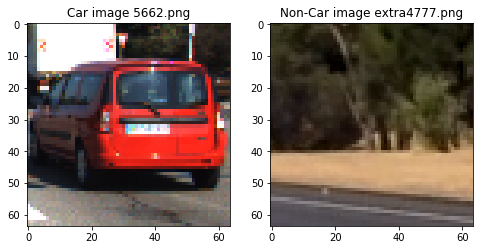

In [29]:
#get training data from various 

car_images = glob.glob("vehicles/*/*.png")
noncar_images = glob.glob("non-vehicles/*/*.png")

print ("Total No. of Images with Car : ", len(car_images))
print ("Total No. of Images without Car : ",len(noncar_images))

# pick 5 random images from both the set and visualize 

for i in range (0,1):
    
    car_random= rd.randint(0,len(car_images))
    noncar_random = rd.randint(0,len(noncar_images))
    figc , axisc = plt.subplots(1,2,figsize=(8,8))
    axisc[0].imshow(plt.imread(car_images[car_random]))
    axisc[0].set_title("Car image " + car_images[car_random].split("\\")[-1] )
    axisc[1].imshow(plt.imread(noncar_images[noncar_random]))
    axisc[1].set_title("Non-Car image " + noncar_images[noncar_random].split("\\")[-1] )

### Feature Extraction

In [30]:
# functions for extracting features

# to get bin spatial features
def bin_spatial(img,size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img,size).ravel()
    # Return the feature vector
    return features

#to get color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256),visualize=True):
    # Compute the histogram of the Passed channels separately
    
    
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    if visualize == False :
        return hist_features
    
    else :
        
        # Generating bin centers
        edges = channel1_hist[1]
        bin_centers = (edges[1:] + edges[0:len(edges)-1])/2
               
        # Return the individual histograms, bin_centers and feature vector
        return hist_features,channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

#to get HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block,visualize=False, feature_vector=True):
    
    if visualize == False:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',transform_sqrt=True, 
                       visualise=visualize, feature_vector=feature_vector)
        return features

    # Otherwise call with one output
    else:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=visualize, feature_vector=feature_vector)
        return features, hog_image

#function to combine all the features
def combine_features(img, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        bin_spatialFlag=True, color_histFlag=True,visualize=False):
    
        
    # apply color conversion if other than 'BGR'
    if color_space != 'BGR':
        color_change= eval("cv2.COLOR_BGR2" + color_space)
        changeImage = cv2.cvtColor(img,color_change)
          
    else:
        changeImage = np.copy(img)      

    if bin_spatialFlag == True:
            
        spatial_features = bin_spatial(changeImage, size=spatial_size)
            
    if color_histFlag == True:
            
        hist_features = color_hist(changeImage, nbins=hist_bins,visualize=visualize)
            
    # run get_hog_features to get HOG features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(changeImage.shape[2]):
            hog_features.append(get_hog_features(changeImage[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        visualize=False, feature_vector=True))
        hog_feature = np.ravel(hog_features)        
            
    else:
        hog_feature = get_hog_features(changeImage[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, visualize=False, feature_vector=True)
        
    if bin_spatialFlag == True and color_histFlag==True :
        feature=np.concatenate((hog_feature,spatial_features, hist_features))
        
    elif bin_spatialFlag==True :
        feature=np.concatenate((hog_feature,spatial_features))
            
    elif color_histFlag==True:
        feature=np.concatenate((hog_feature,hist_features))
            
    else:
        feature=hog_feature
    
    # Return list of feature vectors
    return feature
    

### Train Classifier

In [37]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feature = True # Spatial features on or off
hist_feature = True # Histogram features on or off


In [38]:
# extract features 

car_features=[]
noncar_features=[]
for carimage in car_images:
    
    #read images 
    img = cv2.imread(carimage)
    car_feature = combine_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feature, color_histFlag=hist_feature)
    car_features.append(car_feature)

print ("Car Feature Shape :",car_features[0].shape)    
print ("Total No. of Images Processed :" , len(car_features))
for noncarimage in noncar_images:
    
    #read image
    img = cv2.imread(noncarimage)
    noncar_feature = combine_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feature, color_histFlag=hist_feature)
    noncar_features.append(noncar_feature)
    
print ("Non-Car Feature Shape :",noncar_features[0].shape) 
print ("Total No. of Images Processed :" , len(noncar_features))

Car Feature Shape : (4884,)
Total No. of Images Processed : 8792
Non-Car Feature Shape : (4884,)
Total No. of Images Processed : 8968


In [39]:
# get Xtrain , YTrain and XTest and YTest from the features collected .


# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)

print ("Total Data (car & non-car) : ", len(X))
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print ("Total Ground Truth Data (car & non-car) : ", len(y))

X,y = shuffle(X,y)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print ("Total Train Data (car & non-car) : ", len(X_train))
print ("Total Ground Truth Data (car & non-car) : ", len(y_train))

print ("Total Test Data (car & non-car) : ", len(X_test))
print ("Total Ground Test Data (car & non-car) : ", len(y_test))

Total Data (car & non-car) :  17760
Total Ground Truth Data (car & non-car) :  17760
Total Train Data (car & non-car) :  14208
Total Ground Truth Data (car & non-car) :  14208
Total Test Data (car & non-car) :  3552
Total Ground Test Data (car & non-car) :  3552


In [40]:
# train the data 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4884
22.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9772


In [41]:
model_saver = {}
model_saver["classifier"] = svc
model_saver["data_scaler"]= X_scaler
pickle.dump( model_saver, open( "model_saver_YUV.p", "wb" ) )


In [42]:
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))

Train Accuracy of SVC =  1.0


### Apply Sliding window

In [4]:
# functions for sliding windows
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Resize , extract feature , predict classifier , draw box

In [5]:
def search_cars(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, visualise=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        resize_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using combine_features()
        features = combine_features(resize_img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        bin_spatialFlag=spatial_feat, color_histFlag=hist_feat)
        
        #5) Scale extracted features to be fed to classifier
        scaled_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(scaled_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [ ]:
# # test on images
# image = cv2.imread('test_images/test1.jpg')
# draw_image = np.copy(image)
# y_start_stop= [400,680]

# windows = slide_window(image, x_start_stop=[0, image.shape[1]], y_start_stop=y_start_stop, 
#                     xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# hot_windows = search_cars(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feature, 
#                         hist_feat=hist_feature)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 128, 128), thick=6)                    

# final_image = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)


# fig, axis = plt.subplots(1,2,figsize=(16,16))
# axis[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
# axis[0].set_title("Original Image")
# axis[1].imshow(final_image)
# axis[1].set_title("Image with Car Detection")



#### Apply Heat Map to combine various bounding boxes and reduce false positive

In [14]:

#
def get_heatMap (heatmap, boundingBoxes):
    # iterate through the bounding boxes
    for box in boundingBoxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # return the updated heat map
    return heatmap

def define_threshold_heatMap(heatmap,threshold=2):
    #set zero , were values less than threshold
    heatmap[heatmap<=threshold]=0
    # return updated heatmap
    return heatmap

def apply_heatMap(img,boundingBoxes,threshold,visualise=False):
    # get an array similar to image with zero's , use only single channel
    heatmap = np.zeros_like (img[:,:,0],np.float)
    
    #get heat map for the bounding boxes
    heatmap_ret = get_heatMap(heatmap,boundingBoxes)
    
    #apply threshold to heatmap returned from above function
    heatmap_thresh = define_threshold_heatMap(heatmap_ret,threshold)
    
    #apply numpy.clip so that all values are with in range of 0-255
    heatmap_res= np.clip(heatmap_thresh, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_res)
        
    result= draw_labeled_bboxes(img, labels)
    
    if visualise == True :
        
        return result,heatmap_res
    
    else:
        
        return result

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img    

def apply_avg_heatMap(img,avgboundingBoxes,threshold,visualise=False):
    
    #combine all retangle values
    boundingBoxes=[]
    
    for bb_outer in avgboundingBoxes:
        for bb in bb_outer:
            boundingBoxes.append(bb)
        
    # get an array similar to image with zero's , use only single channel
    heatmap = np.zeros_like (img[:,:,0],np.float)
    
    #get heat map for the bounding boxes
    heatmap_ret = get_heatMap(heatmap,boundingBoxes)
    
    #apply threshold to heatmap returned from above function
    heatmap_thresh = define_threshold_heatMap(heatmap_ret,threshold)
    
    #apply numpy.clip so that all values are with in range of 0-255
    heatmap_res= np.clip(heatmap_thresh, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap_res)
        
    result= draw_labeled_bboxes(img, labels)
    
    if visualise == True :
        
        return result,heatmap_res
    
    else:
        
        return result


In [ ]:
# # test heat map function 
# # test on images
# image = cv2.imread('test_images/test3.jpg')
# draw_image = np.copy(image)
# y_start_stop= [400,600]
# x_start_stop= [(image.shape[1]//2), image.shape[1]]
# threshold=1.8



# # windows = slide_window(image, x_start_stop=[(image.shape[1]//2), image.shape[1]], y_start_stop=y_start_stop, 
# #                     xy_window=(96, 96), xy_overlap=(0.6, 0.5))

# slide1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(64,64), xy_overlap=(0.15, 0.15))
# slide2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(96,96), xy_overlap=(0.2, 0.2))
# slide3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(128,128), xy_overlap=(0.25, 0.25))
# slide4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(32,32), xy_overlap=(0.5, 0.5))

# windows = slide1 + slide2 +  slide3 + slide4

# hot_windows = search_cars(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feature, 
#                         hist_feat=hist_feature)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 128, 128), thick=6)                    

# withoutHeatMap_image = cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)

# final_image,heat_map_img = apply_heatMap (draw_image,hot_windows,threshold,visualise=True)

# fig, axis = plt.subplots(2,2,figsize=(16,8))
# axis[0][0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
# axis[0][0].set_title("Original Image")
# axis[0][1].imshow(withoutHeatMap_image)
# axis[0][1].set_title("Image with Car Detection MultiBoxes")

# axis[1][0].imshow(heat_map_img,cmap='hot')
# axis[1][0].set_title("Heat Map")
# axis[1][1].imshow(cv2.cvtColor(final_image,cv2.COLOR_BGR2RGB))
# axis[1][1].set_title("Final Image with Car Detection")

In [49]:

def pipeline(img):
    global load_model
    global classifier
    global data_scalar
    global windows
    global prev_windows
    global frameNo , threshold
    
    #convert image to BGR 

    
    imgBGR = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    draw_image = np.copy(imgBGR)
    y_start_stop1= [400,600]
    y_start_stop2= [450,680]
    y_start_stop3= [400,450]
    x_start_stop= [(img.shape[1]//2), img.shape[1]]
    threshold=30
    
    if load_model== True :
        model_data= pickle.load(open("model_saver_YUV.p","rb"))
        classifier = model_data["classifier"]
        data_scalar = model_data["data_scaler"]
        slide3 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop3, 
                    xy_window=(32,32), xy_overlap=(0.50, 0.50))
        slide1 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop1, 
                    xy_window=(64,64), xy_overlap=(0.80, 0.80))
        slide2 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop2, 
                    xy_window=(96,96), xy_overlap=(0.80, 0.80))
        
     
        windows = slide1 + slide2 #+  slide3 #+ slide4
        print ("No of Windows ", len(windows))
        load_model =False
    
    
#     slide1 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(64,64), xy_overlap=(0.15, 0.15))
#     slide2 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(96,96), xy_overlap=(0.2, 0.2))
#     slide3 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(128,128), xy_overlap=(0.25, 0.25))
#     slide4 = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
#                     xy_window=(32,32), xy_overlap=(0.5, 0.5))

#     print (" windows length ", len(windows))
#     print (" X start " , x_start_stop)
    
#     hot_windows = search_cars(draw_image, windows, classifier, data_scalar, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feature, 
#                         hist_feat=hist_feature)        
      

    randomframe =  rd.randint(0,3)
    
    if frameNo == randomframe :
        #process the frame
        ret_window = search_cars(draw_image, windows, classifier, data_scalar, color_space=color_space, 
                       spatial_size=spatial_size, hist_bins=hist_bins, 
                       orient=orient, pix_per_cell=pix_per_cell, 
                       cell_per_block=cell_per_block, 
                       hog_channel=hog_channel, spatial_feat=spatial_feature, 
                       hist_feat=hist_feature) 
#         print ("frame processed ", frameNo)
        prev_windows.append(ret_window)
        
        if len(prev_windows) > 10 :
            prev_windows.pop(0)
            
        threshold = 30 + len(prev_windows)
    
    if frameNo == 3:
        frameNo=0
    else :
        frameNo+=1
    
    
#     finalImage = apply_heatMap (draw_image,prev_windows,threshold,visualise=False)
    finalImage = apply_avg_heatMap (draw_image,prev_windows,threshold,visualise=False)
    #convert back to RGB
    result = cv2.cvtColor(finalImage,cv2.COLOR_BGR2RGB)
    
    return result

In [ ]:
# test pipeline
#  = plt.imread('test_images/test1.jpg')
load_model =True
loc = "Testing_Images/"
# loc = "test_images/test"
# traverese from the previous list
for i in range(935,958):
    fname=loc + str(i) + ".jpg"
    img = plt.imread(fname)
    res = pipeline(img)
    
    res_fig , res_axis = plt.subplots(1,2, figsize=(16, 8))
       
    res_axis[0].imshow(img)
    res_axis[0].set_title("Original " + fname.split('/')[-1] , fontsize=10)
    res_axis[1].imshow(res)
    res_axis[1].set_title("With Cars " + fname.split('/')[-1] , fontsize=10)


In [ ]:

def save_clip(img):
    global i
    plt.imsave("Testing_Images/" + str(i) + ".jpg",img)
    i += 1
    return img

i =0 
load_model =True
windows= None
prev_windows= []
frameNo=0
# create video using pipeline
output = 'project_video_output_5_3.mp4'
clip2 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(save_clip) #NOTE: this function expects color images!!
clipProcessed = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time clipProcessed.write_videofile(output, audio=False)
clipProcessed.reader.close()
clipProcessed.audio.reader.close_proc()

No of Windows  820
[MoviePy] >>>> Building video project_video_output_5_3.mp4
[MoviePy] Writing video project_video_output_5_3.mp4


 48%|██████████████████████████████████████                                         | 607/1261 [06:31<13:44,  1.26s/it]